In [1]:
import sys
sys.path.append("./tacotron2/") # go to parent dir
# from customFunctions import *
sys.path.append("./waveglow/")

In [2]:
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd



In [3]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', 
                       interpolation='none')

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.training_files = './tacotron2/filelists/vlsp/train.txt'

attention_dim: 128
attention_location_kernel_size: 31
attention_location_n_filters: 32
attention_rnn_dim: 1024
batch_size: 16
cudnn_benchmark: false
cudnn_enabled: true
decoder_rnn_dim: 1024
dist_backend: nccl
dist_url: tcp://localhost:54321
distributed_run: false
dynamic_loss_scaling: true
encoder_embedding_dim: 512
encoder_kernel_size: 5
encoder_n_convolutions: 3
epochs: 37
filter_length: 1024
fp16_run: false
gate_threshold: 0.5
grad_clip_thresh: 1.0
hop_length: 256
ignore_layers:
- embedding.weight
iters_per_checkpoint: 200
learning_rate: 0.001
load_mel_from_disk: false
mask_padding: true
max_decoder_steps: 1000
max_wav_value: 32768.0
mel_fmax: 8000.0
mel_fmin: 0.0
n_frames_per_step: 1
n_mel_channels: 80
n_symbols: 150
p_attention_dropout: 0.1
p_decoder_dropout: 0.1
postnet_embedding_dim: 512
postnet_kernel_size: 5
postnet_n_convolutions: 5
prenet_dim: 256
sampling_rate: 22050
seed: 1234
symbols_embedding_dim: 512
text_cleaners:
- flowtron_cleaners
training_files: filelists/vlsp/tra

In [5]:
checkpoint_path = "./tacotron2/checkpoints/checkpoint_52846"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [6]:
from waveglow.denoiser import Denoiser
waveglow_path = './waveglow/checkpoints/waveglow_51729'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

In [7]:
from data_utils import TextMelLoader, TextMelCollate
trainset = TextMelLoader(hparams.training_files, hparams)

In [8]:
textx = "có khói ở xưởng cưa bốc lên ~ và có cả quần áo phơi trên một cái dây #"


In [9]:
inputs=trainset.get_text(
    textx
)
sequence = torch.autograd.Variable(
    inputs.unsqueeze(0)).cuda().long()
sequence.size()
with torch.no_grad():
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

In [10]:
sequence

tensor([[25, 53,  0, 48, 41, 53, 42,  0, 69,  0, 88, 81, 69, 51, 40,  0, 25, 81,
          6,  0, 24, 59, 25,  0, 49, 34, 51,  0,  1,  0, 87,  8,  0, 25, 53,  0,
         25, 11,  0, 71, 75, 20, 51,  0,  7, 52,  0, 70, 41, 64, 42,  0, 74, 72,
         34, 51,  0, 50, 61, 74,  0, 25,  7, 42,  0, 26, 18, 89]],
       device='cuda:0')

In [11]:
# mel_outputs, mel_outputs_postnet, _, alignments

In [12]:
# trainset.text_embedding.symbol2numeric_dict
sequence.size()

torch.Size([1, 68])

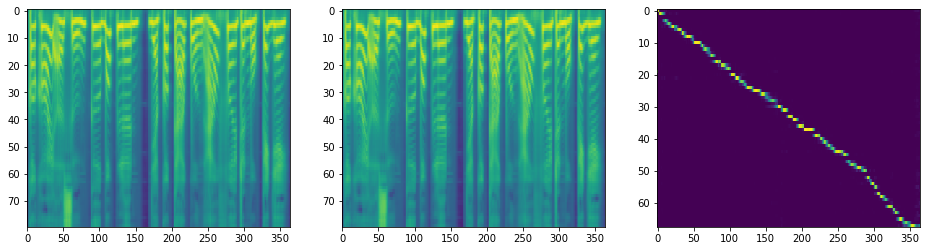

In [13]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [14]:
z=torch.mean(mel_outputs_postnet[0], dim=1).detach().cpu().numpy()
z

array([-3.428, -3.152, -2.982, -2.201, -1.365, -1.02 , -1.448, -2.22 ,
       -2.672, -2.773, -2.719, -2.662, -2.547, -2.541, -2.752, -3.09 ,
       -3.195, -3.17 , -3.102, -3.146, -3.338, -3.53 , -3.74 , -3.912,
       -4.027, -3.951, -3.908, -3.904, -4.066, -4.227, -4.27 , -4.19 ,
       -4.145, -4.285, -4.47 , -4.46 , -4.477, -4.492, -4.59 , -4.625,
       -4.566, -4.715, -4.9  , -4.88 , -4.926, -5.043, -5.11 , -5.16 ,
       -5.27 , -5.223, -5.207, -5.125, -5.05 , -5.06 , -4.984, -4.902,
       -4.766, -4.727, -4.844, -4.934, -4.895, -4.914, -4.87 , -5.07 ,
       -5.55 , -5.637, -5.7  , -5.8  , -5.906, -5.953, -5.883, -5.89 ,
       -5.934, -6.06 , -5.973, -5.76 , -5.504, -5.574, -5.688, -5.668],
      dtype=float16)

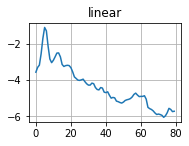

In [15]:
plt.subplot(221)
plt.plot(np.arange(z.shape[0]), z)
plt.yscale('linear')
plt.title('linear')
plt.grid(True)

In [15]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet,sigma=1.)
# with torch.no_grad():
#     audio = waveglow.infer(z.unsqueeze(0).float().to("cuda").half(),sigma=1.)

In [16]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
a = np.array(audio_denoised[0].data.cpu().numpy())


In [17]:
ipd.Audio(a, rate=hparams.sampling_rate, autoplay=True)

In [66]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import librosa
import IPython.display as ipd
a = np.array(audio[0].data.cpu().numpy())

a,index = librosa.effects.trim(a, top_db=40)
# ipd.Audio(a, rate=hparams.sampling_rate)

In [67]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
a = np.array(audio_denoised[0].data.cpu().numpy())

a,index = librosa.effects.trim(a, top_db=40)
ipd.Audio(a, rate=hparams.sampling_rate)

In [78]:
a

array([ 0.01702943,  0.01271552,  0.01053264, ..., -0.03971424,
       -0.03443998, -0.02579231], dtype=float32)

In [45]:
from scipy.io.wavfile import write
# normalize audio for now
a = a/ np.abs(a).max()
# a = a[:hparams['sampling_rate'] * 3]
import os
write("./out.wav", hparams['sampling_rate'], a)

In [65]:
a.astype(np.int16)

array([ -995, -1386, -1783, ...,  3774,  4076,  3887], dtype=int16)

In [68]:
librosa.output.write_wav('file_trim_5s.wav', a,hparams['sampling_rate'])

AttributeError: module 'librosa' has no attribute 'output'

In [68]:
hparams['sampling_rate']

22050

In [64]:
z=trainset.get_mel("./tacotron2/filelists/vlsp/wavs_train/07271.wav")

In [30]:
z.unsqueeze(0).float().to("cuda")

tensor([[[ -7.6114,  -6.9149,  -4.5901,  ...,  -5.1608,  -5.0065,  -5.1246],
         [ -8.2182,  -7.3237,  -4.9716,  ...,  -5.3795,  -5.0775,  -5.3920],
         [ -8.4934,  -7.3825,  -5.1712,  ...,  -5.1540,  -5.7225,  -6.2172],
         ...,
         [-10.7848, -10.0147,  -8.4081,  ...,  -8.3630,  -8.5582,  -8.5523],
         [-11.4279, -10.3909,  -8.2990,  ...,  -8.4469,  -8.6181,  -8.7357],
         [-10.4379,  -9.7481,  -7.8345,  ...,  -8.1815,  -8.8624,  -9.2118]]],
       device='cuda:0')

In [ ]:
z -mel_outputs_postnet.squeeze(0)

In [ ]:
mel_outputs_postnet.size(),z.size()

In [ ]:
torch.mean(mel_outputs_postnet[0,:,:341].cpu() - z.cpu())

In [50]:
torch.exp(z)

tensor([[4.9476e-04, 9.9293e-04, 1.0152e-02,  ..., 5.7369e-03, 6.6945e-03,
         5.9488e-03],
        [2.6970e-04, 6.5970e-04, 6.9324e-03,  ..., 4.6100e-03, 6.2356e-03,
         4.5529e-03],
        [2.0481e-04, 6.2202e-04, 5.6777e-03,  ..., 5.7761e-03, 3.2715e-03,
         1.9948e-03],
        ...,
        [2.0713e-05, 4.4736e-05, 2.2304e-04,  ..., 2.3334e-04, 1.9196e-04,
         1.9309e-04],
        [1.0887e-05, 3.0712e-05, 2.4876e-04,  ..., 2.1456e-04, 1.8080e-04,
         1.6074e-04],
        [2.9302e-05, 5.8407e-05, 3.9584e-04,  ..., 2.7979e-04, 1.4161e-04,
         9.9855e-05]])